# Why do we do pre-processing?

# Example dataset -> Chadwick
![image](/home/dtasev/temp/presentation/image.png)

In [1]:
# Setup the package, this is done automatically with the startup scripts
import os
import sys

# Setup some constants
HOME = os.path.expanduser('~')
CHADWICK_PATH = os.path.join(HOME, 'win_img', 'chadwick_insert')
CHADWICK_SAMPLE_PATH = os.path.join(CHADWICK_PATH, 'Data')
CHADWICK_DARK_PATH = os.path.join(CHADWICK_PATH, 'Dark_Tomo')
CHADWICK_FLAT_PATH = os.path.join(CHADWICK_PATH, 'Open_Tomo_BeforeInsert')

ISIS_IMAGING_PATH = os.path.join(HOME, 'isis_imaging')
print("Home Dir ->", HOME, "\nDataset Path ->", CHADWICK_PATH, "\nPackage Path ->", ISIS_IMAGING_PATH)
# Append the ISIS Imaging path so that Python can find the package
sys.path[0] = ISIS_IMAGING_PATH

import isis_imaging
print("Package name ->", isis_imaging.__package__)

Home Dir -> /home/dtasev 
Dataset Path -> /home/dtasev/win_img/chadwick_insert 
Package Path -> /home/dtasev/isis_imaging
Package name -> isis_imaging


In [2]:
import matplotlib

# Setup matplotlib to use the notebook backend
matplotlib.use('nbagg')

from matplotlib import pyplot

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
# Loading data

In [3]:
# Load some data in, format for indices is [start, end, step]
indices = [0, 1570, 100]
images = isis_imaging.io.loader.load(CHADWICK_SAMPLE_PATH, CHADWICK_FLAT_PATH, CHADWICK_DARK_PATH, indices=indices)

In [4]:
# The file returned is of a type Images
assert isinstance(images, isis_imaging.io.loader.Images)

# print the public methods
list(filter(lambda x: "__" not in x, dir(isis_imaging.io.loader.Images)))

['check_data_stack', 'get_dark', 'get_filenames', 'get_flat', 'get_sample']

In [7]:
# Use matplotlib to visualise the image and a histogram
def show(image):
    fig, img_axes = pyplot.subplots(nrows=1,ncols=1)
    
    image_obj = img_axes.imshow(image.get_sample()[0], cmap='Greys_r')
    
    hist_axes = fig.add_axes([0.25, 0.925, 0.5, 0.08])
    hist_axes.hist(image.get_sample()[0].flatten(), bins=2048)

    pyplot.show()
    
def show2(image):
    fig, img_axes = pyplot.subplots(nrows=1,ncols=1)
    
    image_obj = img_axes.imshow(image, cmap='Greys_r')
    
    hist_axes = fig.add_axes([0.25, 0.925, 0.5, 0.08])
    hist_axes.hist(image.flatten(), bins=2048)

    pyplot.show()

<IPython.core.display.Javascript object>


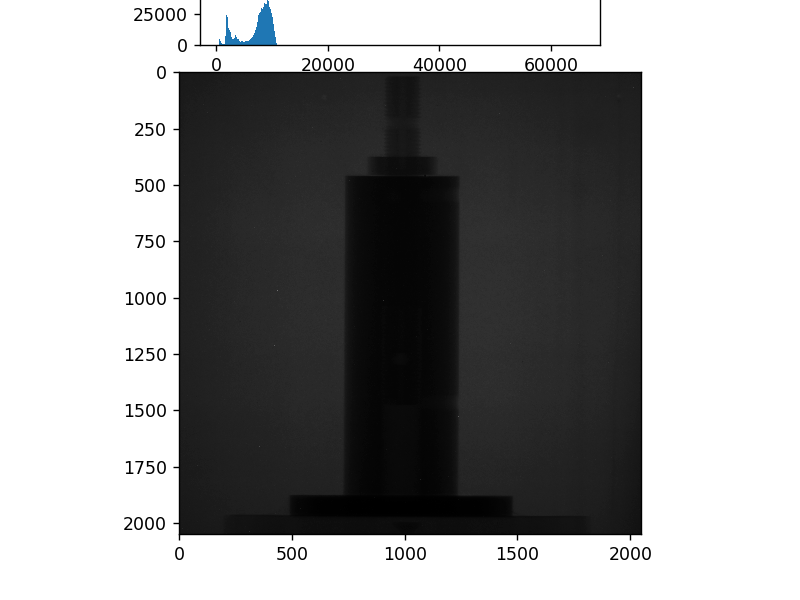

<IPython.core.display.Javascript object>


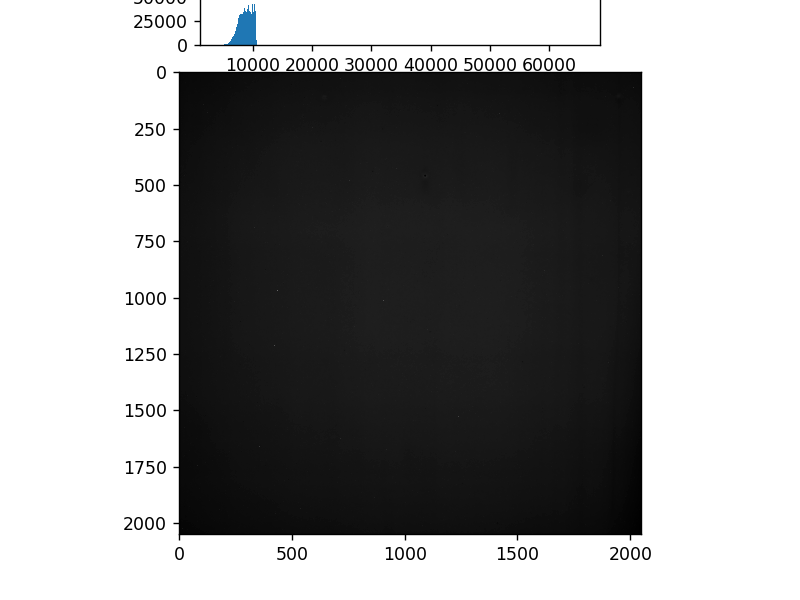

<IPython.core.display.Javascript object>


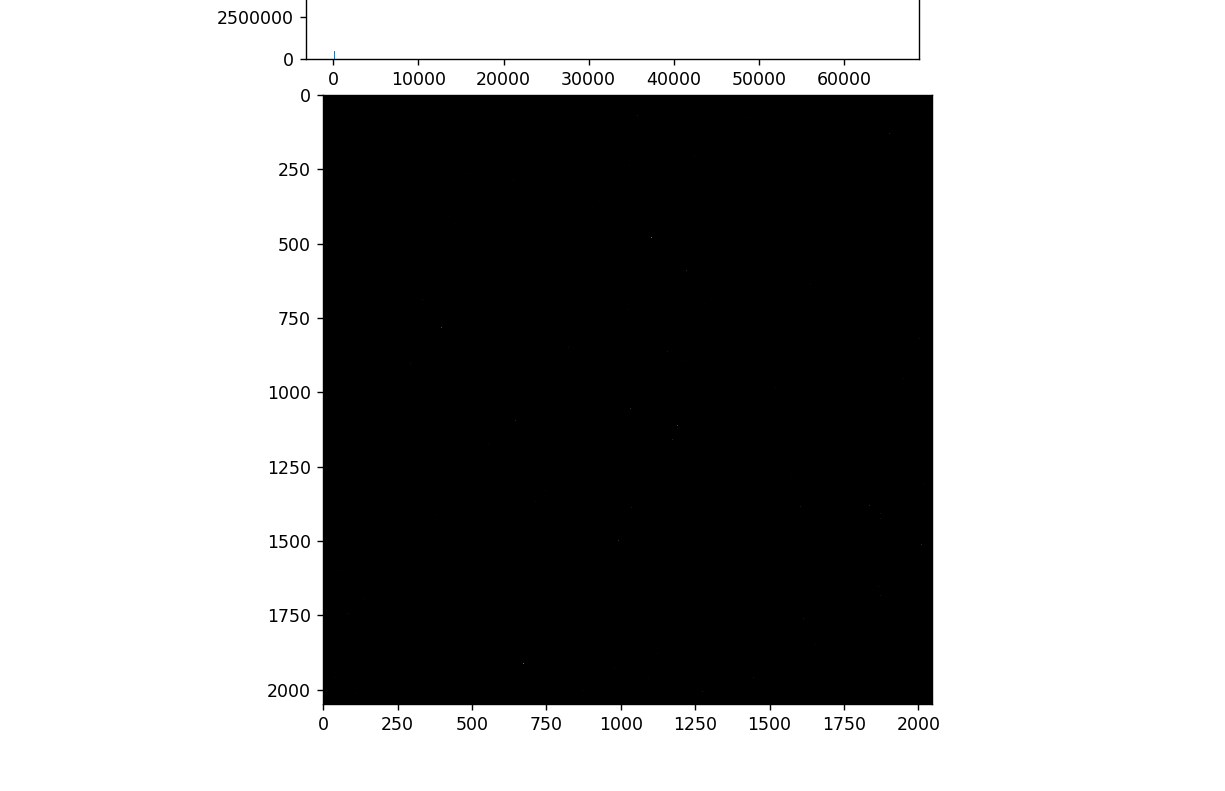

In [8]:
show(images)

# Flat and Dark images are usually between 30-60, 
# but we load all of them in and then take the average of all the images

# Flat are also called Open Beam and are images that are 
# run after the instrument/experiment is set up, but without the actual sample
show2(images.get_flat())

# Dark images are gathered from running the camera with a 
# closed shutter, showing any bad pixels from the camera itself
show2(images.get_dark())

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
# Background Correction

 ---Starting PARALLEL normalization by flat/dark images.
 ---Finished PARALLEL normalization by flat/dark images. Elapsed time: 0.4471852779388428 sec.


<IPython.core.display.Javascript object>


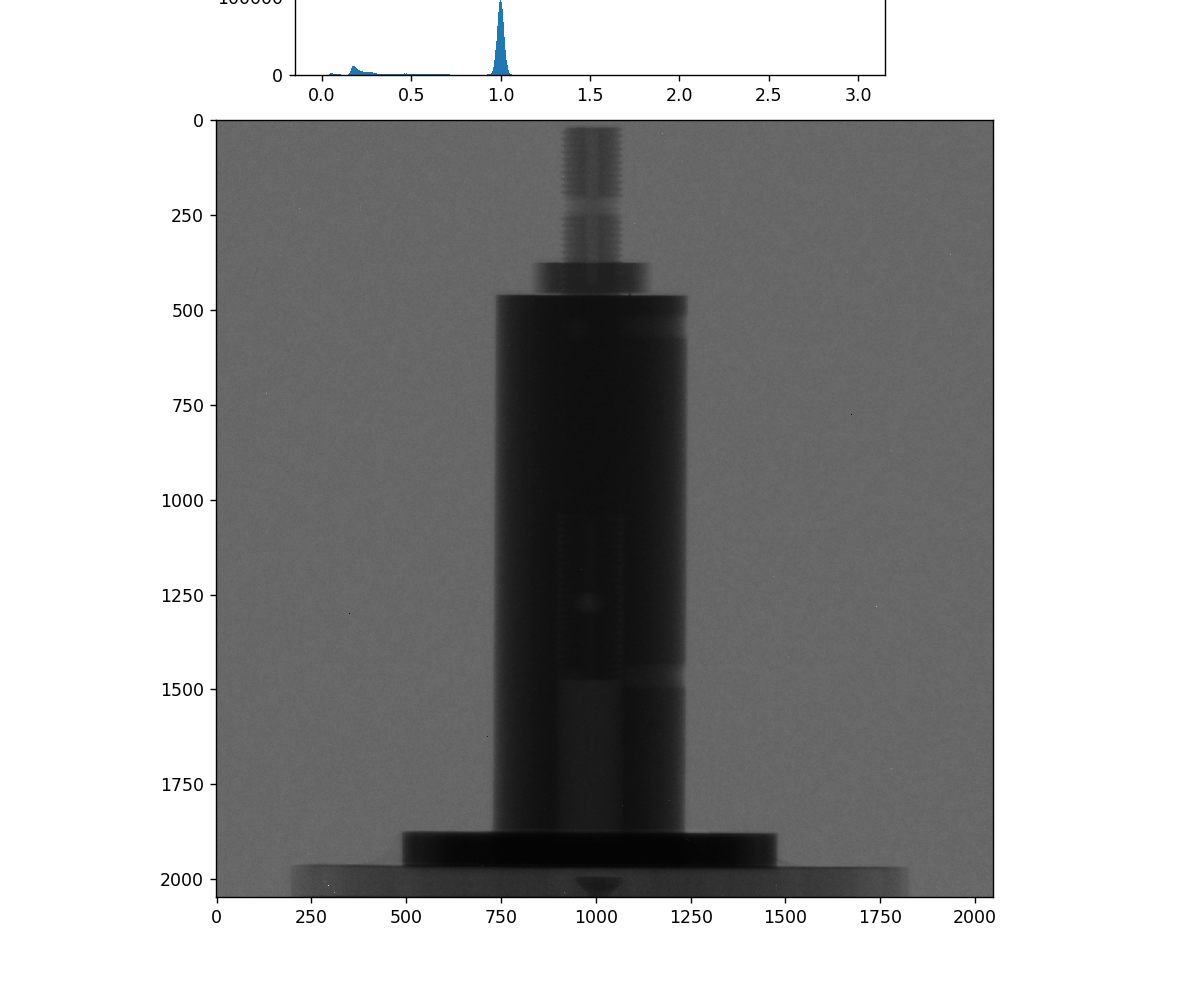

In [9]:
from isis_imaging.core.algorithms import value_scaling
from isis_imaging.core.filters import background_correction

scale_factors = value_scaling.create_factors(images.get_sample())

# Background Correction
# We need sample, flat (open beam without an object) and dark (closed shutter) images
background_correction.execute(images.get_sample(), images.get_flat(), images.get_dark())
show(images)

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
# Some images might have slightly lower/higher values, due to changes in the flux

<IPython.core.display.Javascript object>


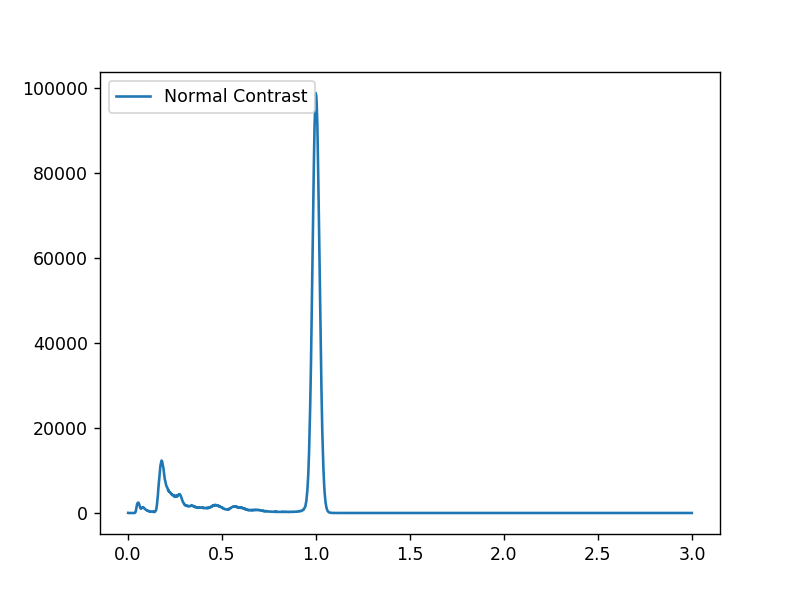

<IPython.core.display.Javascript object>


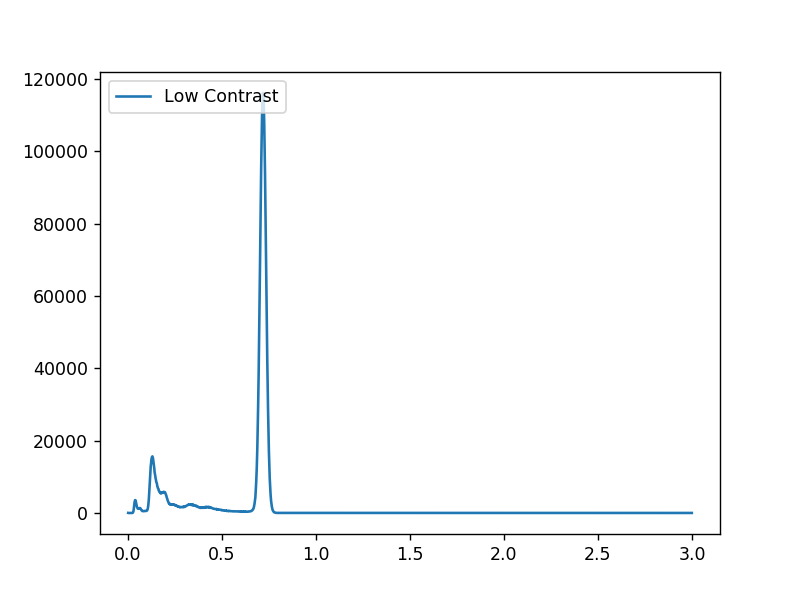

<module 'matplotlib.pyplot' from '/home/dtasev/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/pyplot.py'>

In [10]:
from isis_imaging.gui.stack_visualiser import sv_histogram

# Show difference in histograms, but we don't want to look at two different plots
sv_histogram.show_transparent(images.get_sample()[0].flatten(), "Normal Contrast", "")
sv_histogram.show_transparent(images.get_sample()[5].flatten(), "Low Contrast", "")

# But we don't really want to look at 2 different histograms

In [11]:
# import package from isis_imaging's GUI part
from isis_imaging.gui.stack_visualiser import sv_histogram

# python abuse to plot the histograms on the same plot, it works by default in the package

def plot_histograms_magically():
    # save the original function reference
    temp_func_storage = sv_histogram._show
    def _temporary_empty_function(): pass
    
    # set to a function that does nothing
    sv_histogram._show = _temporary_empty_function

    sv_histogram.show_transparent(images.get_sample()[0].flatten(), "Normal Contrast", "")

    # restore so that the plot is shown next time
    sv_histogram._show = temp_func_storage

    sv_histogram.show_transparent(images.get_sample()[5].flatten(), "Low Contrast", "Magic")

<IPython.core.display.Javascript object>


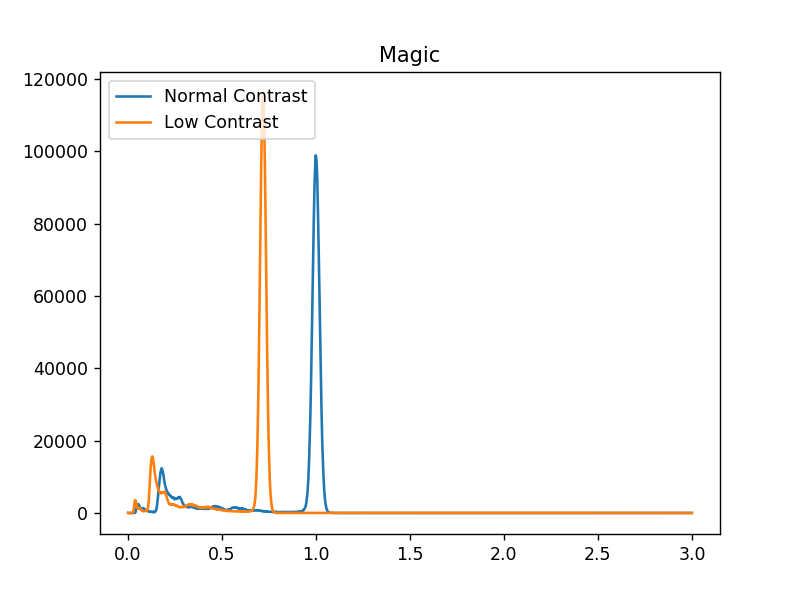

In [12]:
plot_histograms_magically()

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
# Normalisation by Region of Interest

In [13]:
AIR_REGION = (1348, 732, 1436, 846)
print("Air Region", *AIR_REGION)



# Normalisation by Air Region (Contrast Normalisation)

from isis_imaging.core.filters import roi_normalisation

# Normalise by region of interest
roi_normalisation.execute(images.get_sample(), AIR_REGION)

# and scale up the values to uint16 range (0-65535)
value_scaling.apply_factor(images.get_sample(), scale_factors)

Air Region 1348 732 1436 846
 ---Starting normalization by air region...
 ---Finished normalization by air region. Average: 0.9815869331359863, max ratio: 1.0221989154815674, min ratio: 0.73102205991745. Elapsed time: 0.39980316162109375 sec.


array([[[ 7014.68310547,  7027.13232422,  7273.15234375, ...,
          7232.45849609,  7102.59863281,  7246.03662109],
        [ 7121.18457031,  6886.91210938,  7053.61523438, ...,
          7112.72753906,  7404.92138672,  7237.48486328],
        [ 7130.36669922,  7107.29833984,  7195.78466797, ...,
          7212.37255859,  7262.80175781,  7390.48144531],
        ..., 
        [ 7140.82763672,  6971.35498047,  6952.15185547, ...,
          6471.26855469,  7325.96142578,  7139.82128906],
        [ 7122.52929688,  7172.43310547,  7094.04052734, ...,
          6921.50830078,  6643.84570312,  7231.18896484],
        [ 7070.33740234,  6923.85839844,  7181.62011719, ...,
          6890.56787109,  7059.90673828,  6986.40380859]],

       [[ 7003.36962891,  7016.97949219,  7223.00390625, ...,
          7110.00830078,  7025.09326172,  7182.13867188],
        [ 7071.15234375,  6918.10791016,  6923.7578125 , ...,
          7281.85791016,  7214.02539062,  7305.62890625],
        [ 6917.14794922,

<IPython.core.display.Javascript object>


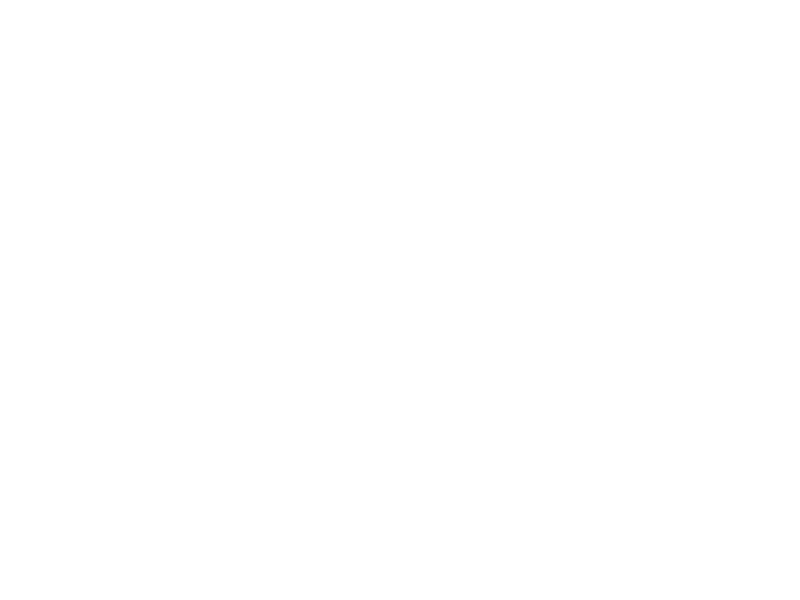

<IPython.core.display.Javascript object>


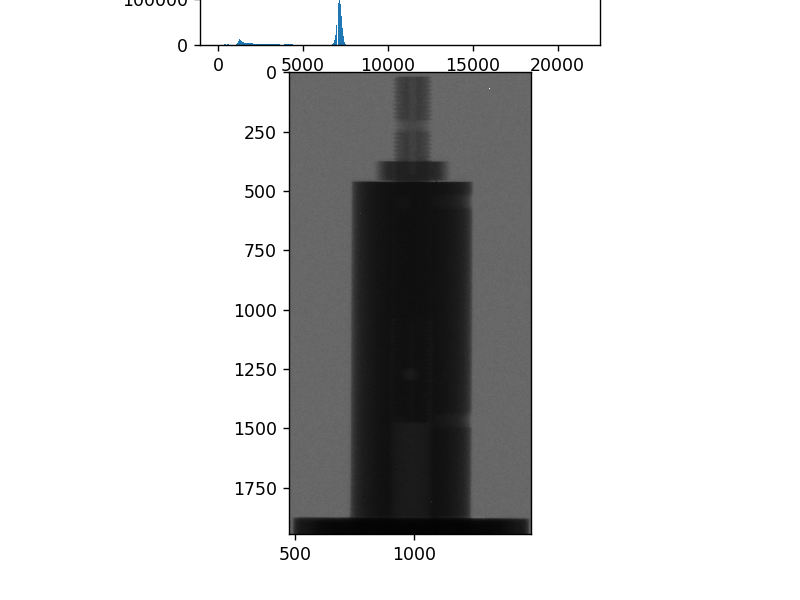

In [14]:
show(images)

<IPython.core.display.Javascript object>


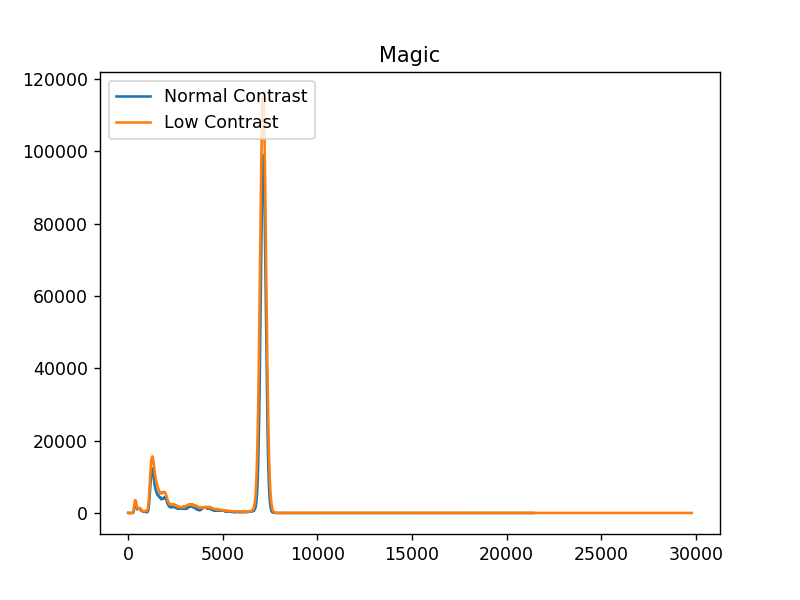

In [15]:
plot_histograms_magically()

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
# Region of Interest crop

In [16]:
ROI = (422, 6, 1492, 1970)
print("ROI", *ROI)

from isis_imaging.core.filters import crop_coords

print("The Region of Interest that we are cropping", ROI)
images.sample, images.flat, images.dark = crop_coords.execute(images.get_sample(), ROI)

ROI 422 6 1492 1970
The Region of Interest that we are cropping (422, 6, 1492, 1970)
 ---Starting cropping with coordinates: (422, 6, 1492, 1970). ...
 ---Finished image cropping with pixel data type: float32, resulting shape: (16, 1964, 1070). Elapsed time: 0.0017216205596923828 sec.


<IPython.core.display.Javascript object>


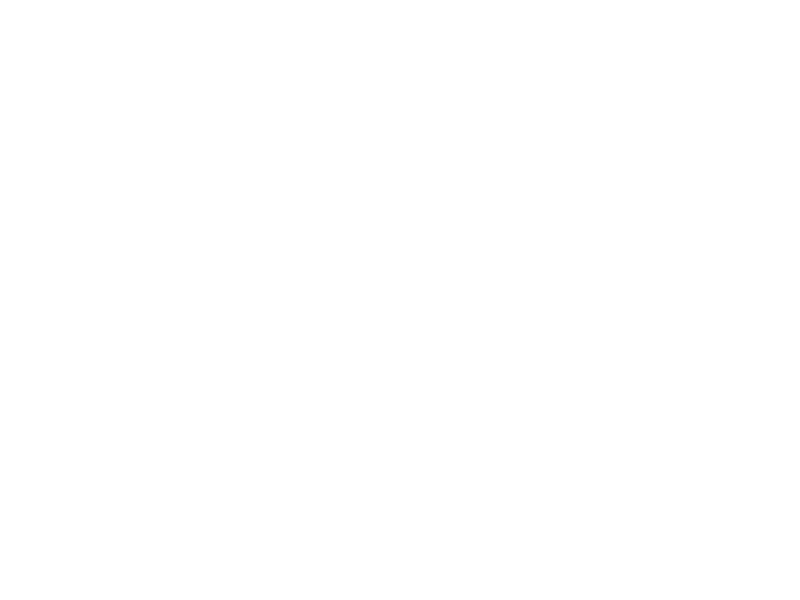

<IPython.core.display.Javascript object>


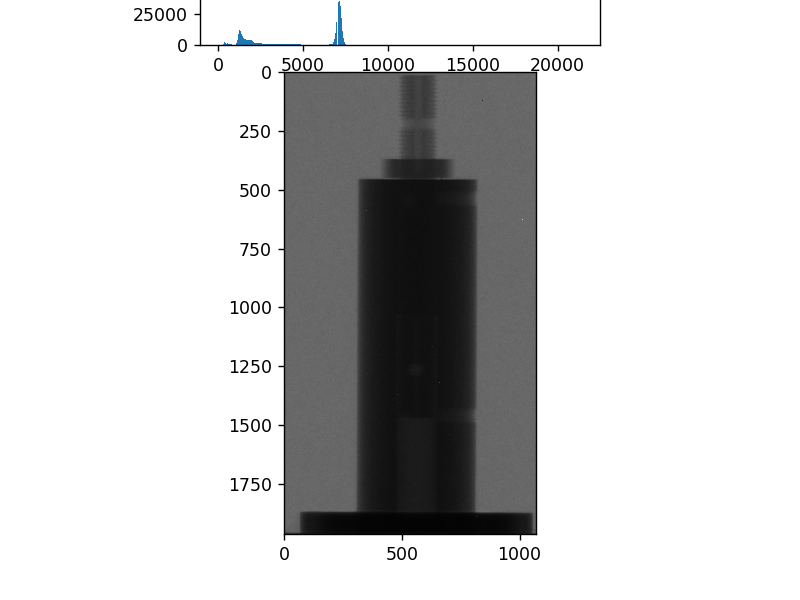

In [17]:
show(images)

<IPython.core.display.Javascript object>


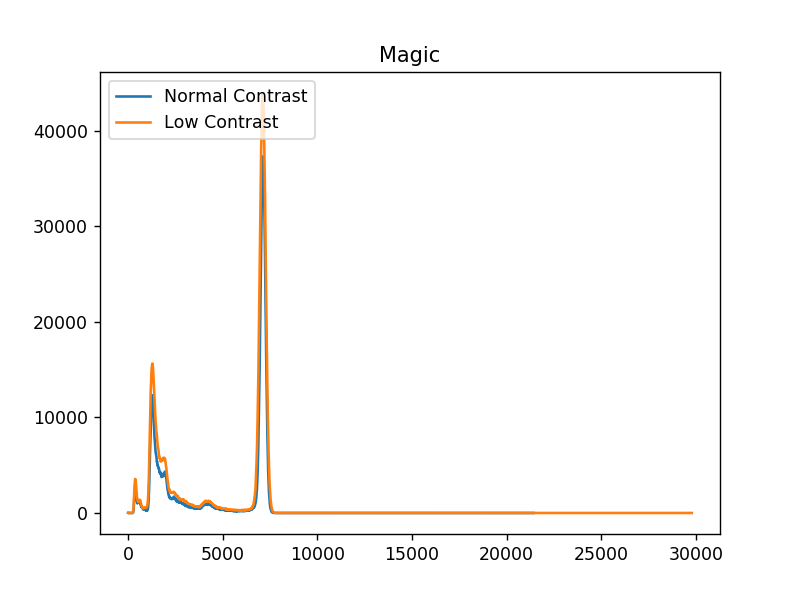

In [18]:
plot_histograms_magically()

## We have not removed _any_ of the data!
## But the noise counts are now a lot less
### Before: 120,000
### Now: 42,000

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
# Reducing the noise further

### Values of noise and data are very distinct

<IPython.core.display.Javascript object>


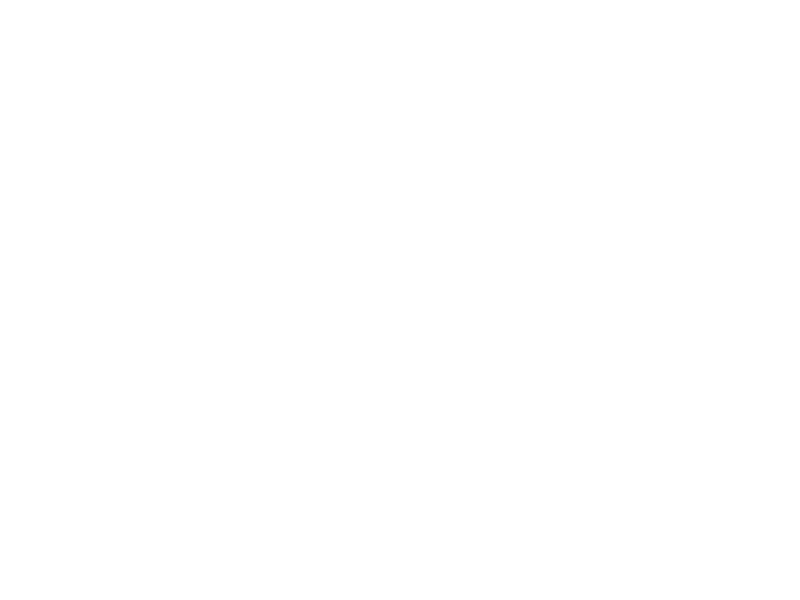

<IPython.core.display.Javascript object>


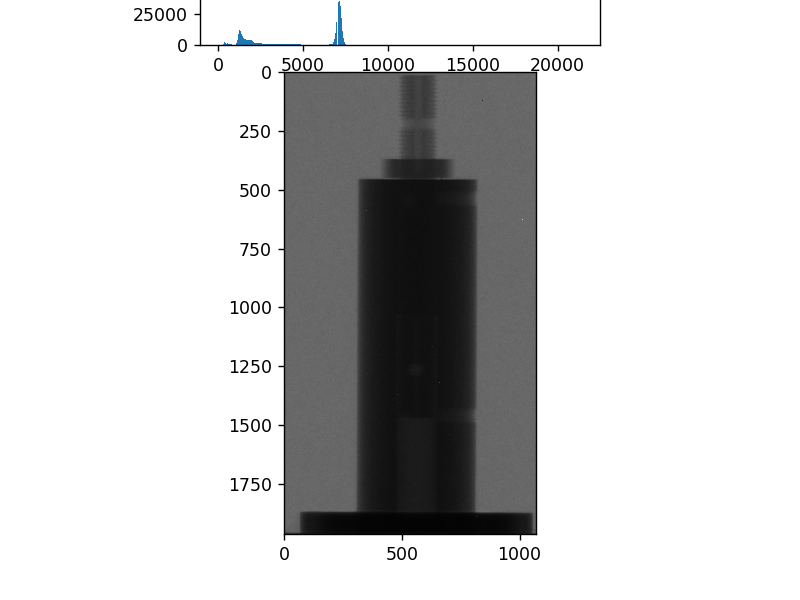

<IPython.core.display.Javascript object>


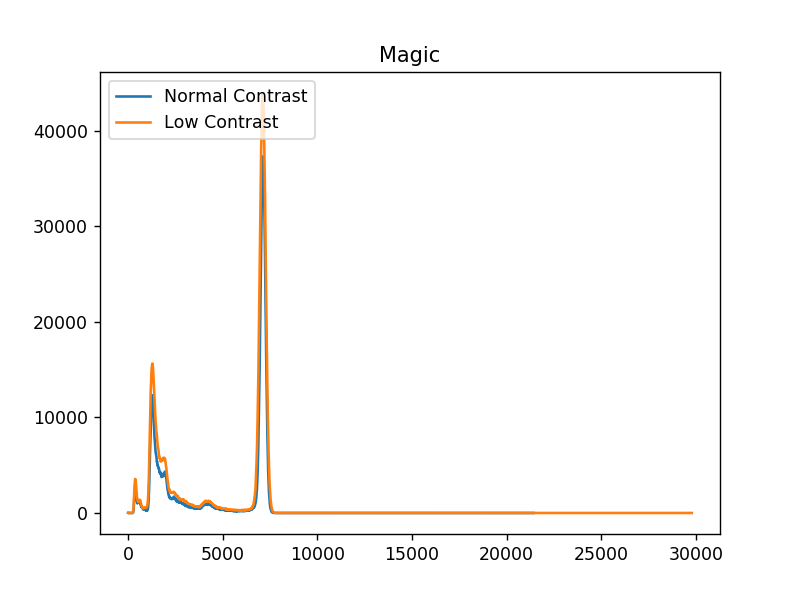

In [19]:
show(images)
plot_histograms_magically()

In [20]:
CLIP_MIN = 0.01
CLIP_MAX = 6200

from isis_imaging.core.filters import clip_values

print("Remove minimum values", CLIP_MIN)
print("Remove maximum values", CLIP_MAX)
clip_values.execute(images.get_sample(), CLIP_MIN, CLIP_MAX)

Remove minimum values 0.01
Remove maximum values 6200
 ---Clipping data with values min 0.01 and max 6200.
 ---Finished data clipping. Elapsed time: 0.13310551643371582 sec.


array([[[ 6200.        ,  6200.        ,  6200.        , ...,
          6200.        ,  6200.        ,  6200.        ],
        [ 6200.        ,  6200.        ,  6200.        , ...,
          6200.        ,  6200.        ,  6200.        ],
        [ 6200.        ,  6200.        ,  6200.        , ...,
          6200.        ,  6200.        ,  6200.        ],
        ..., 
        [ 3644.52319336,  3771.5925293 ,  3768.5871582 , ...,
          4895.51660156,  4933.90087891,  4928.72167969],
        [ 3591.16552734,  3645.87817383,  3627.76489258, ...,
          4368.72314453,  4437.76220703,  4355.37890625],
        [ 3824.2253418 ,  3708.94213867,  3696.140625  , ...,
          3905.7277832 ,  3974.29345703,  3852.97216797]],

       [[ 6200.        ,  6200.        ,  6200.        , ...,
          6200.        ,  6200.        ,  6200.        ],
        [ 6200.        ,  6200.        ,  6200.        , ...,
          6200.        ,  6200.        ,  6200.        ],
        [ 6200.        ,

<IPython.core.display.Javascript object>


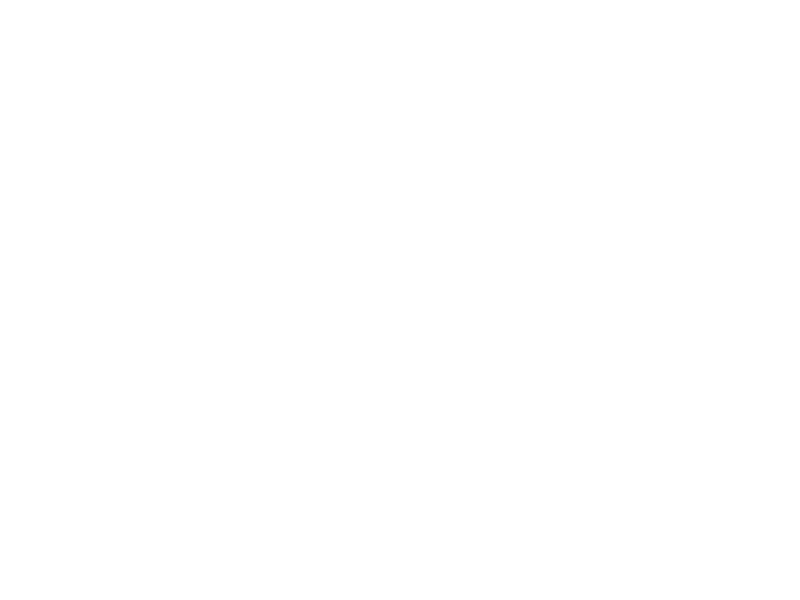

<IPython.core.display.Javascript object>


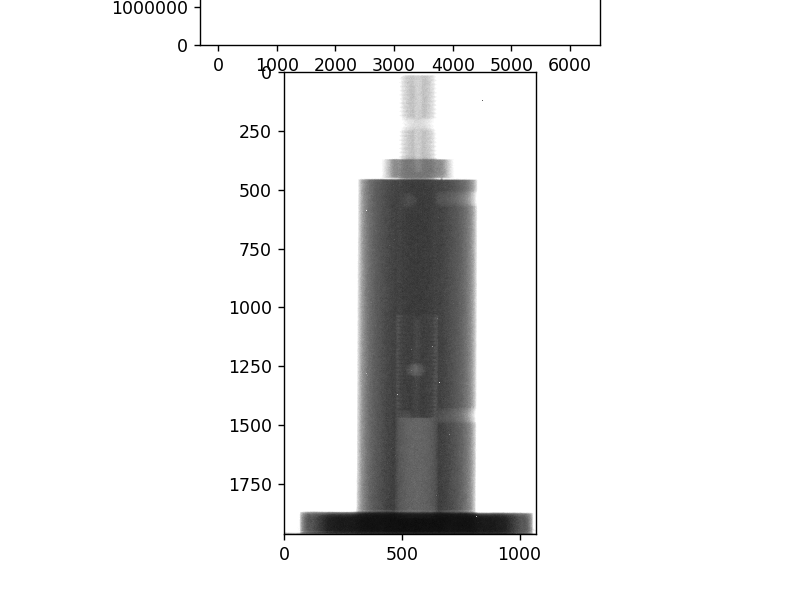

In [21]:
show(images)

<IPython.core.display.Javascript object>


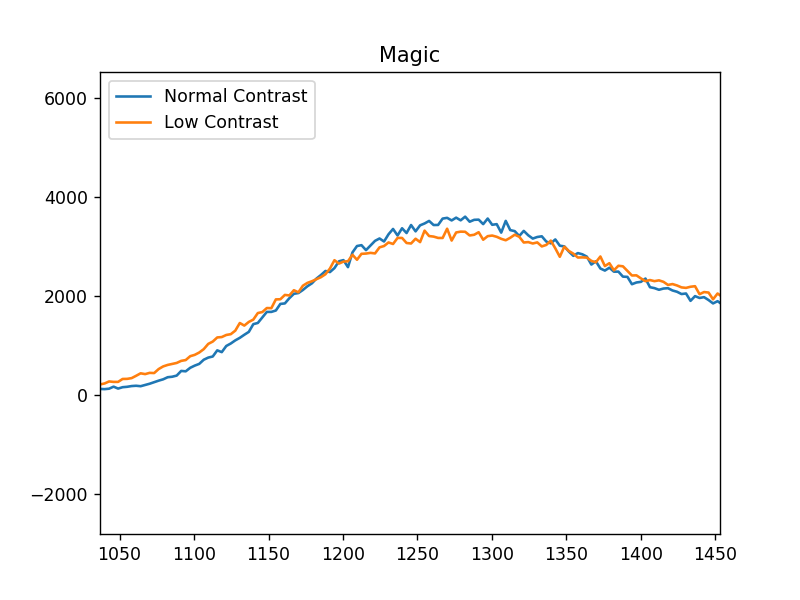

In [22]:
plot_histograms_magically()

In [23]:
from isis_imaging.core.filters import minus_log

# Invert the histogram and reduce the range
images.sample = minus_log.execute(images.get_sample())

 ---Calculating -log on the sample data.
 ---Finished calculating -log on the sample data. Elapsed time: 0.47980690002441406 sec.


<IPython.core.display.Javascript object>


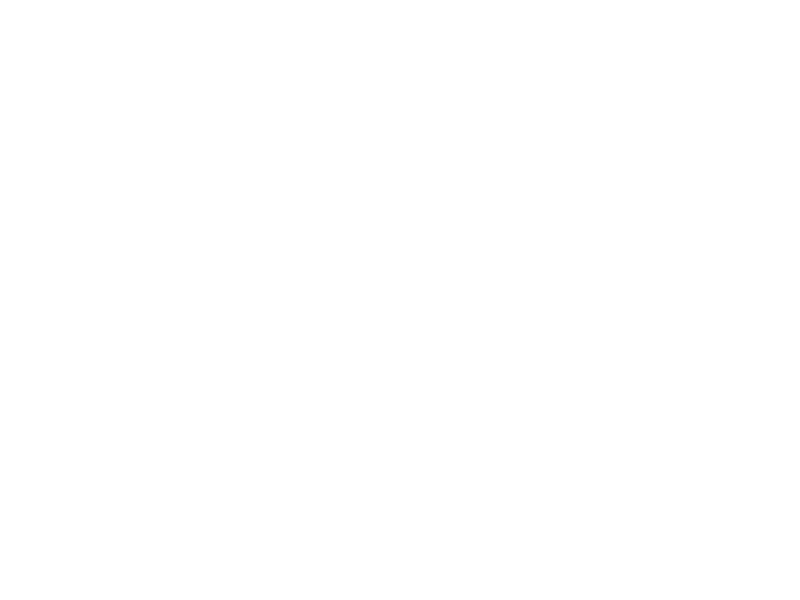

<IPython.core.display.Javascript object>


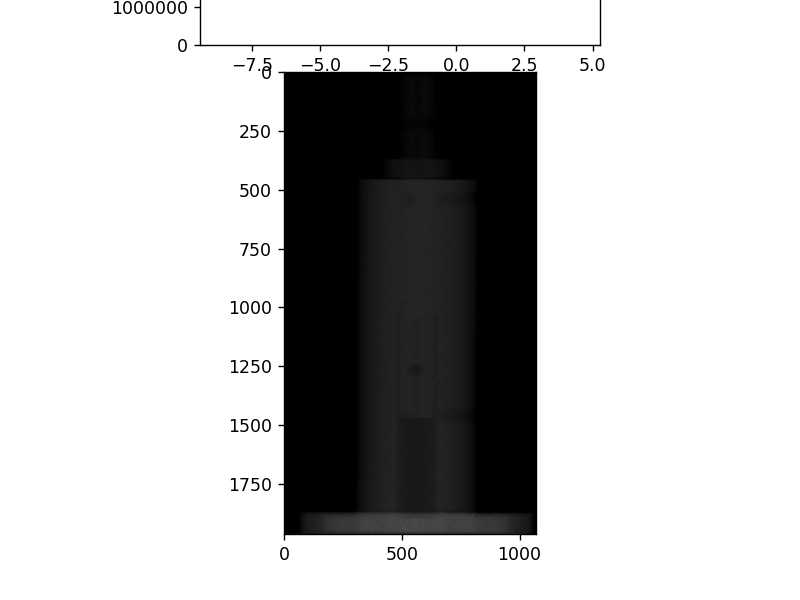

In [24]:
show(images)

<IPython.core.display.Javascript object>


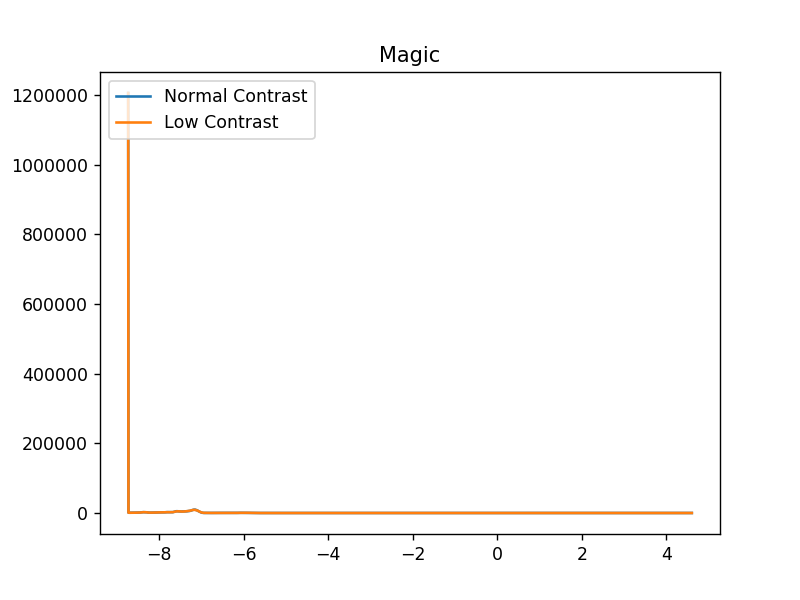

In [25]:
plot_histograms_magically()